# Laboratory exercise 4

### Forest Fires Dataset

##### By: Angela Madjar, 181010

For this laboratory exercise, I decided to work with the Forest Fire Dataset which represents a Regression Problem.

The table of content of this notebook is as follows:



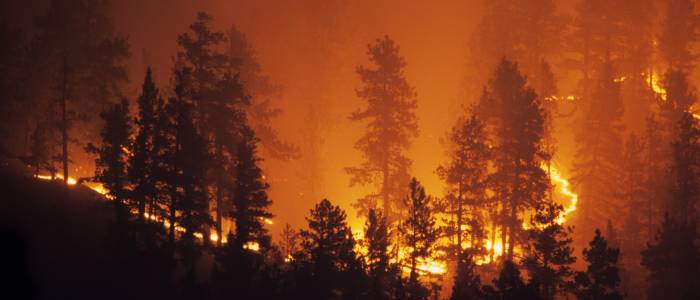

   1. **X** - x-axis spatial coordinate within the Montesinho park map: 1 to 9 
   2. **Y** - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. **month** - month of the year: "jan" to "dec" 
   4. **day** - day of the week: "mon" to "sun"
   5. **FFMC** - FFMC index from the FWI system: 18.7 to 96.20 
   6. **DMC** - DMC index from the FWI system: 1.1 to 291.3 
   7. **DC** - DC index from the FWI system: 7.9 to 860.6 
   8. **ISI** - ISI index from the FWI system: 0.0 to 56.10
   9. **temp** - temperature in Celsius degrees: 2.2 to 33.30
   10. **RH** - relative humidity in %: 15.0 to 100
   11. **wind** - wind speed in km/h: 0.40 to 9.40 
   12. **rain** - outside rain in mm/m2 : 0.0 to 6.4 
   13. **area** - the burned area of the forest (in ha): 0.00 to 1090.84 
   
**Fuel moisture codes:** FFMC (Fine Fuel Moisture Code), DMC (Duff Moisture Code), DC (Drought Code) <br>
**Fire behavior indices:** ISI (Initial Spread Index)


In [3421]:
import pandas as pd
import numpy as np

#libraries needed for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

from scipy.special import boxcox, inv_boxcox #libraries for transformating the dependent variable
import scipy.stats
from sklearn.model_selection import train_test_split #library for splitting the dataset
from sklearn.preprocessing import RobustScaler, StandardScaler #libraries for scaling the dataset
from sklearn.decomposition import PCA #library for dimensionality reduction

#Libraries needed for feature selection
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_regression

#Libraries needed for training & evaluating models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
import xgboost as xgb

#Library needed for basis feature expansion
from sklearn.preprocessing import PolynomialFeatures

#Libraries needed for Deep Learning
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

In [4012]:
df = pd.read_csv('forestfires.csv')

*Getting to know the dataset*

In [3166]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


*Checking the shape of the dataset*

In [3167]:
nRows, nCols = df.shape
print(f'This dataset has {nRows} rows and {nCols} columns.')

This dataset has 517 rows and 13 columns.


*Checking the attribute types* <br>

We notice that all of the attributes are numerical, except for the **day** and the **month**. <br>
These two attributes are strings. Therefore we will have to encode them later (in section 1.2. Encoding categorical variables). <br>

We can also notice that **there are no null values**.

In [3168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


*Checking some basic statistics*

In [3169]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


*Data uniqueness per column*

In [3170]:
df.nunique()

X          9
Y          7
month     12
day        7
FFMC     106
DMC      215
DC       219
ISI      119
temp     192
RH        75
wind      21
rain       7
area     251
dtype: int64

*Percentage of unique values in the whole dataset*

In [3171]:
total_cells = np.product(df.shape)
unique_values_count = df.nunique().sum()
total_unique = unique_values_count.sum()
(total_unique/total_cells)*100

18.449635470912067

### 1. Preprocessing

#### 1.1. Handling duplicates

*Checking if there are any duplicate rows in the dataset* <br>

Since **there are duplicates**, we have to find them and remove them.

In [4013]:
print(df.duplicated().any())

True


*Selecting duplicate rows except the first occurrence based on all columns*

In [4014]:
duplicateRowsDF = df[df.duplicated()]

print("     Duplicate Rows except first occurrence based on all columns are:\n")
print(duplicateRowsDF)

     Duplicate Rows except first occurrence based on all columns are:

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
53   4  3   aug  wed  92.1  111.2  654.1   9.6  20.4  42   4.9   0.0   0.00
100  3  4   aug  sun  91.4  142.4  601.4  10.6  19.8  39   5.4   0.0   0.00
215  4  4   mar  sat  91.7   35.8   80.8   7.8  17.0  27   4.9   0.0  28.66
303  3  6   jun  fri  91.1   94.1  232.1   7.1  19.2  38   4.5   0.0   0.00


*Dropping the duplicate rows*

In [4015]:
df = df.drop_duplicates()

*Checking the shape of the dataset after dropping the duplicates*

In [4016]:
nRows, nCols = df.shape
print(f'After dropping the duplicate rows, the dataset has {nRows} rows and {nCols} columns.')

After dropping the duplicate rows, the dataset has 513 rows and 13 columns.


In [4017]:
print(df.duplicated().any())

False


#### 1.2. Encoding categorical variables

*Converting the months and the days into integers*

In [4018]:
df.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
df.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

In [4019]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


#### 1.3. Handling skewness

In the description of the dataset, it was mentioned that the output variable - **area** is "*very skewed towards 0.0, thus it may make sense to model with the logarithm transform*". <br>

Let's double check this by visualizing the distribution of this attribute. <br>

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

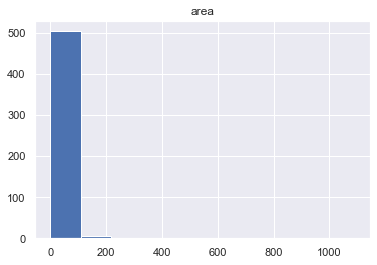

In [3179]:
df.hist(column='area')

In [3180]:
df['area'].skew()

12.802213419146321

We can really see that the area is skewed towards 0.0. If (hypothetically) we took into account the 0.0 values solely, the distribution would look like the Delta distribution. <br>

**Skewed data can mess up the power of our predictive model if we don’t address it correctly.**

Furthermore, we will take the advice and try to penalize and handle the skewness. <br>
We will try out 3 methods and compare the decrease of skewness after applying them. <br>

1. The first one is finding the **Natural Logaritmic** value od the attribute area. 
2. The second one is another effective method for skewness handling called **Box-Cox Transformathion** (I came across this one by doing some research). It transforms non-normal dependent variables into a normal shape. <br>(More details on the following link: https://www.statisticshowto.com/box-cox-transformation/)
3. Finding the **Square root** of the area.

**NOTE**: The first two methods are undefined for values <= 0. Therefore, we will increase the values of the attribute area by adding 1.

Let's first create a copy of the preprocessed dataset.

In [4054]:
df_new = df.copy()

In [4055]:
df_new['area'] = df_new['area'] + 1

In [4056]:
skewness = []

In [4057]:
area_log = np.log(df_new['area'])
skewness.append(pd.Series(area_log).skew())

In [4058]:
area_boxcox = stats.boxcox(df_new['area'])[0]
skewness.append(pd.Series(area_boxcox).skew())

In [4059]:
area_sqrt = np.sqrt(df['area'])
skewness.append(pd.Series(area_sqrt).skew())

In [4060]:
result = pd.DataFrame(data = skewness, columns=['Skewness'], index=['ln', 'box-cox', 'Sqrt'])
result

,Skewness
ln,1.219398
box-cox,0.398623
Sqrt,4.346061


Since the box-cox transformation penalizes the skewness the most, we will use this method for handling skewness of the attribute area.

**In section 7. Linear Regression, I will compare the prediction results obtained with and without applying this transformation.**

In [4061]:
df_new['area'] = stats.boxcox(df_new['area'])[0]

*Visualizing the distribution after handling the skewness*

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

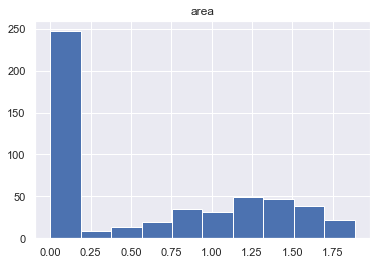

In [3189]:
df_new.hist(column='area')

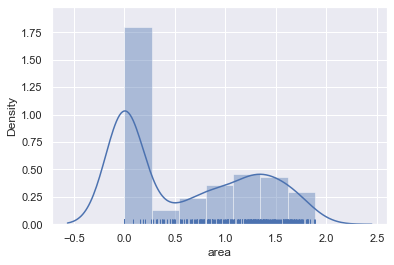

In [3190]:
sns.distplot(df_new['area'],rug=True)
plt.show()

Let's take a look at the distribution of the other attributes. <br>

Some of the other attributes are also skewed, but transforming them leads to an extremely low MSE. A MSE that is extremely low indicates the possibility that the model overfits. Therefore, for now I will only transform the dependent variable - area.

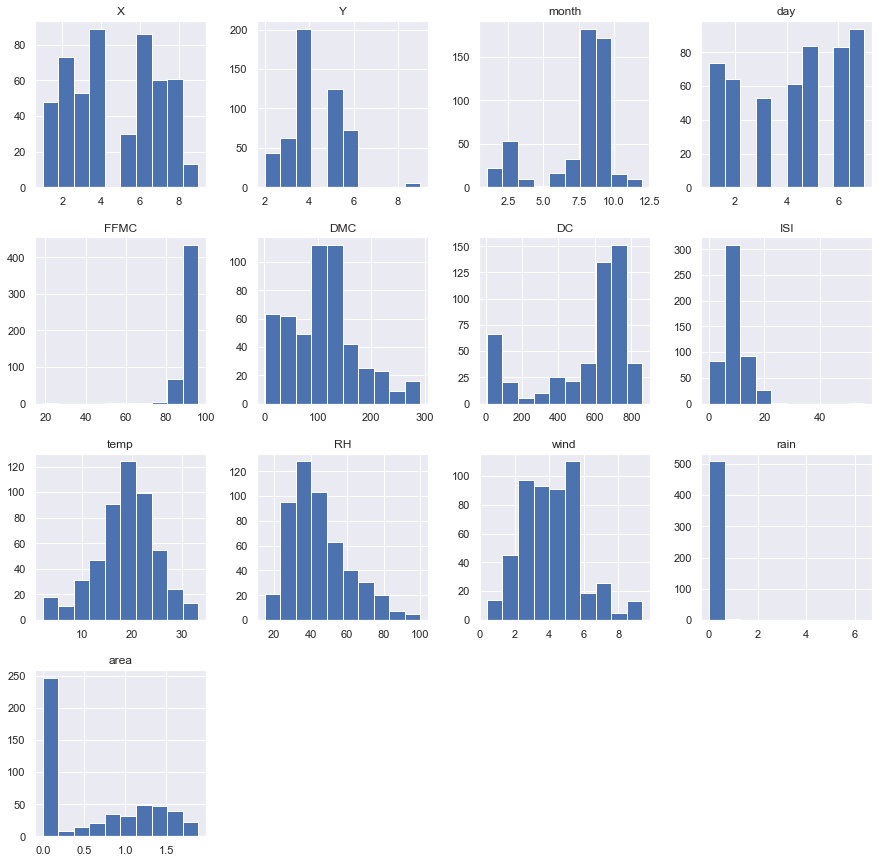

In [3191]:
df_new.hist(figsize=(15,15))
plt.show()

### 2. Visualizations

*Checking the linear correlation of the attributes*

By observing heatmap below, it can be noticed that some of the attributes are highly correlated. <br>
For example, the DC index is higly correlated to the month and the DMC index. <br>
Also, the RH (relative humidity) is inversely correlated with the temperature, meaning the higher the temperature, the lower the humidity.

The high correlation between the attributes indicates the possible need to apply **Feature Selection** (In section **4. Feature Selection**). This should be done after splitting the dataset in order to avoid information  leakage.

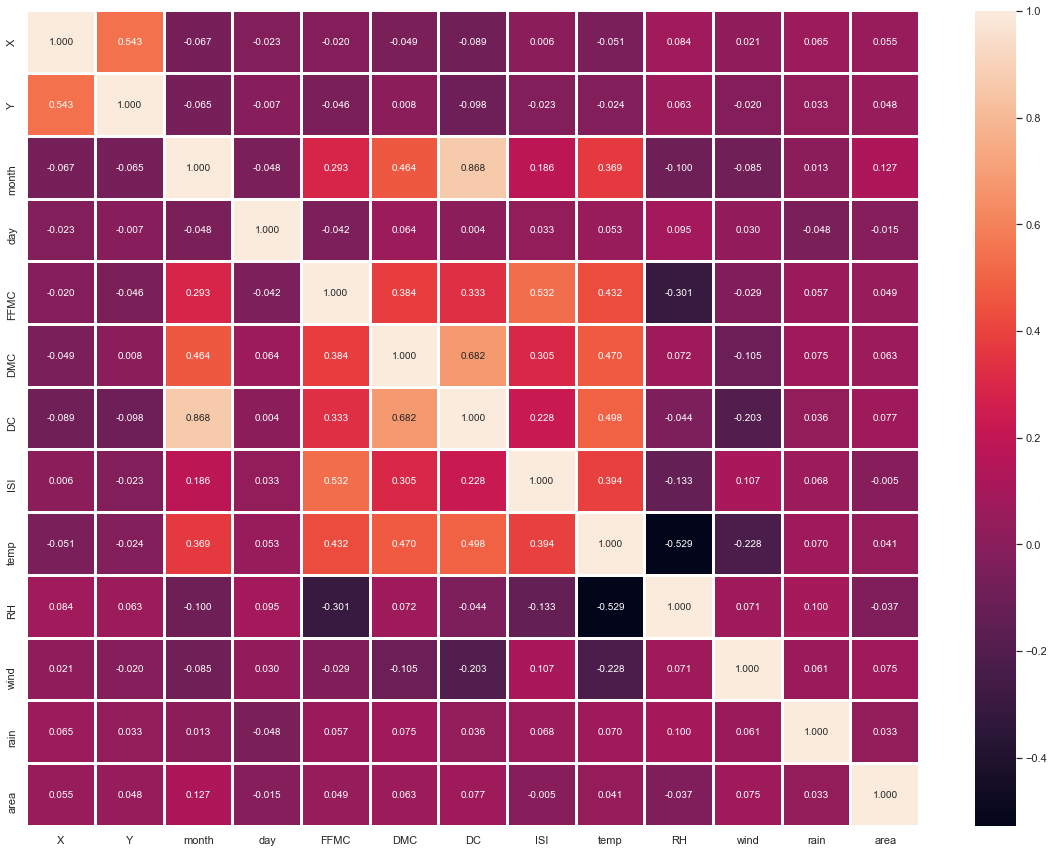

In [2926]:
plt.figure(figsize=(20,15))
sns.heatmap(df_new.corr(), annot=True, fmt='.3f', linewidths=2)
plt.show()

Looking at the pairplot, it's obvious that **there are outliers** in the dataset. Let's try to identify and investigate them closely.

Pairplot segregated on the Burned Area


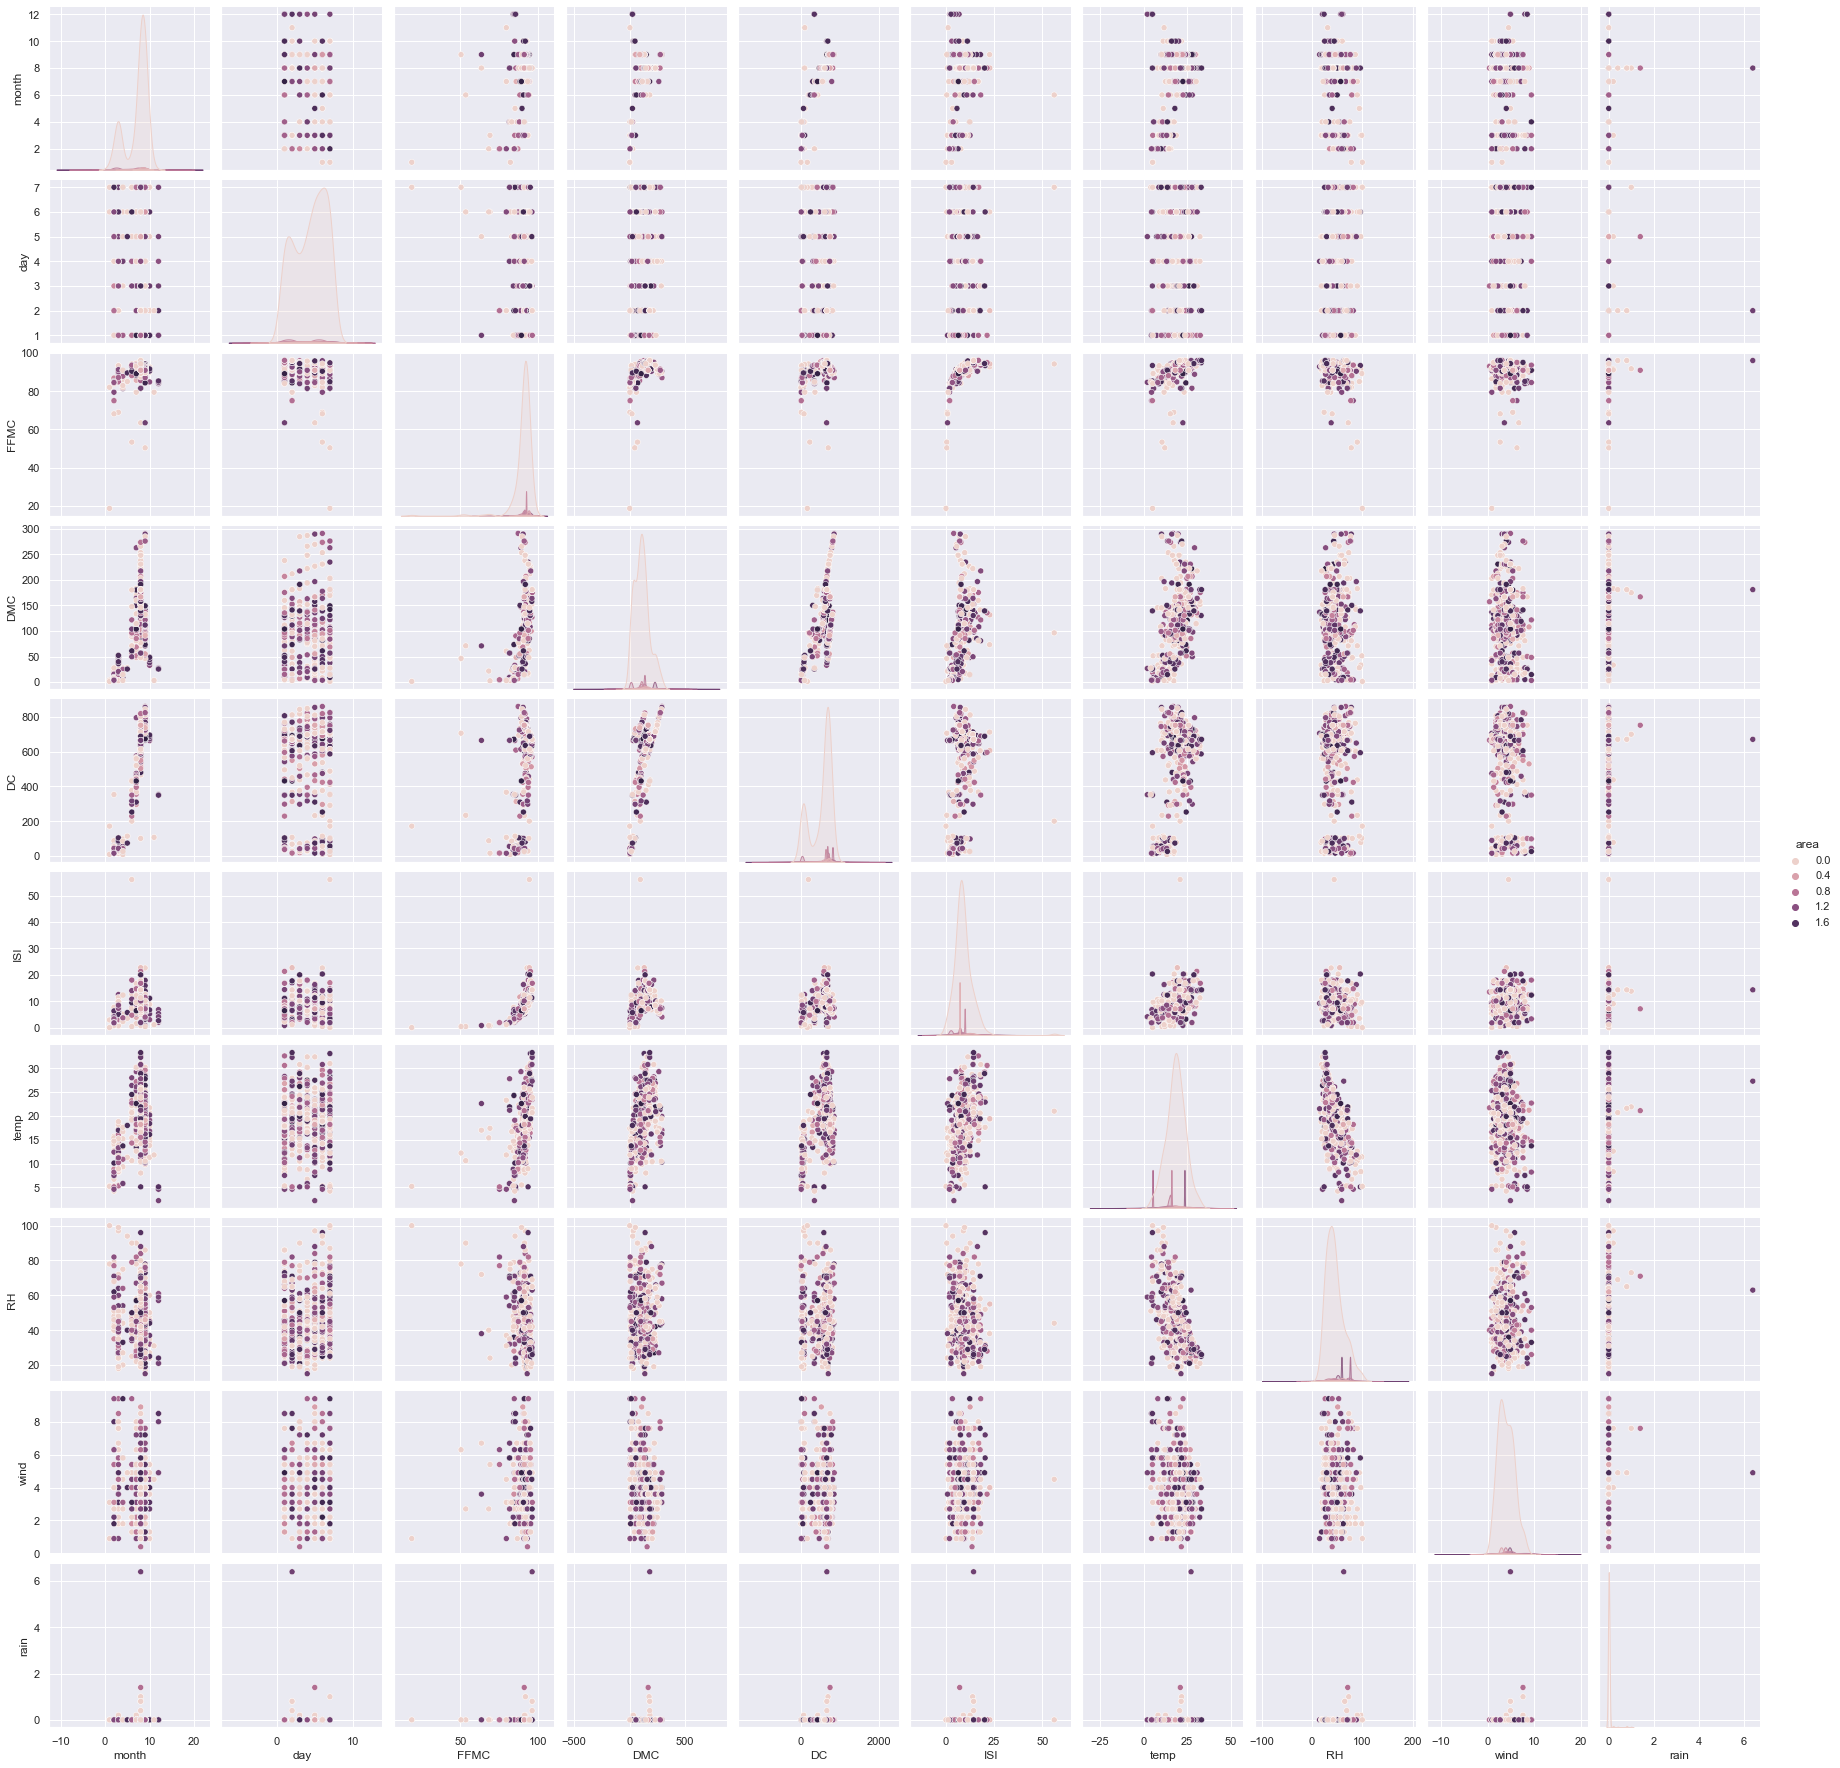

In [2927]:
sns.pairplot(data = df_new[['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']], hue='area')
print('Pairplot segregated on the Burned Area')
plt.show()

### 3. Outliers

Although forest fires in January, February and March seem to be outliers, with a little bit of researching I found out that **forest fires can occur in winter and in spring**. On my surprise, **cold weather, snow storms and dry snow can actually help spread the fire even more**. Therefore, **I will not remove these outliers** as they might be an important group of events. <br> 

Nonetheless, I will also not remove the fires that occured when the temperature was below 5 degrees Celsius because of the already mentioned reason.

Text(0.5, 1.0, 'Month, Day & Temperature Outliers')

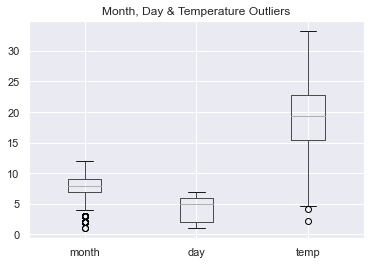

In [2980]:
boxplot = df_new.boxplot(column=['month', 'day', 'temp'])
boxplot.set_title("Month, Day & Temperature Outliers")

Forest fires that occur when it rains heavily (6.4 mm/m2) seem to be an exception. But, I did some reading and descovered that **it must rain havily (at least 20mm) for 1-2 hours in order to put down a forest fire**. Otherwise, the water will just evaporate. Again, **I decided not to drop this outlier**. <br>

Moreover, I learned that **wind increases the supply of oxygen, which results in the fire burning more rapidly**, meaning that I won't exclude the situations where the wind speed is >8km/h.

Text(0.5, 1.0, 'Rain & Wind Outliers')

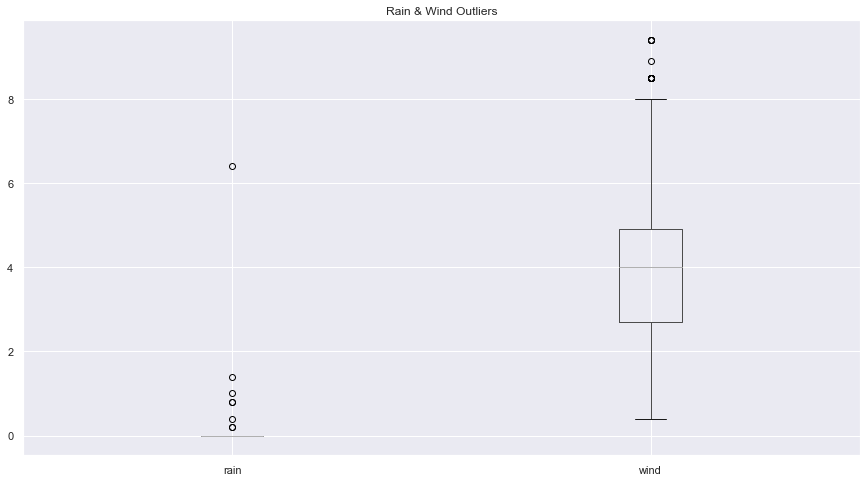

In [1432]:
boxplot = df_new.boxplot(column=['rain', 'wind'])
boxplot.set_title("Rain & Wind Outliers")

Although it is vey unusual for a forest fire to occur when the relative humidity is above 60rh, dropping these rows did not improve the results. Therefore, I decided not to drop them.

Text(0.5, 1.0, 'Relative Humidity Outliers')

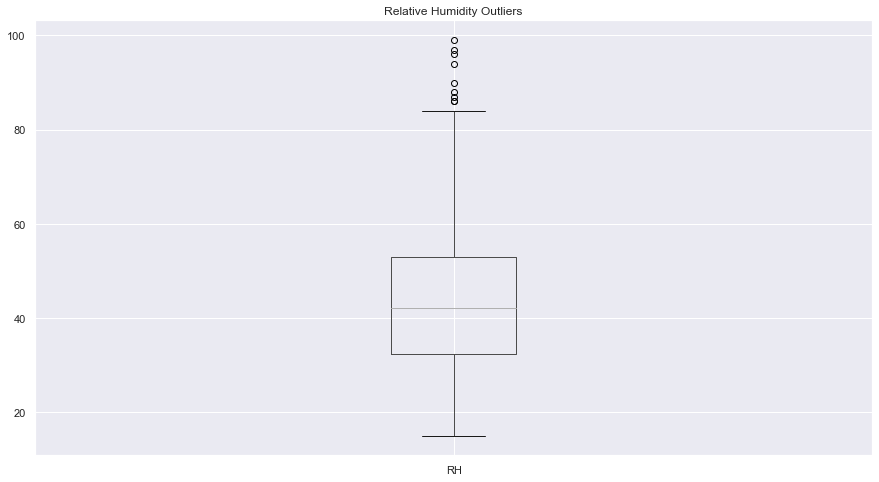

In [1433]:
boxplot = df_new.boxplot(column=['RH'])
boxplot.set_title("Relative Humidity Outliers")

In [3192]:
(df_new['RH'][df_new['RH'] > 80]).count()
#df_new.drop(df_new[df_new['RH'] > 80].index, inplace = True)

There are only 5 rows in which the FFMC is less than 70. Dropping them slightly improved the results.

Text(0.5, 1.0, 'FFMC Index Outliers')

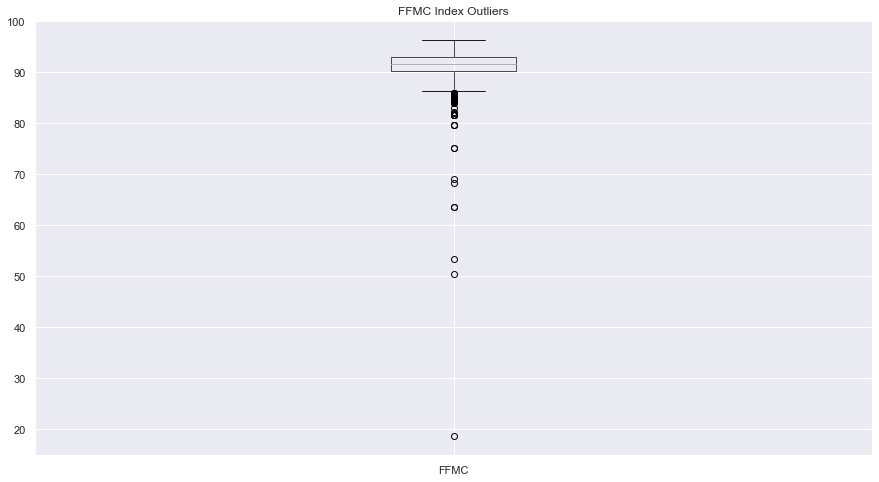

In [363]:
boxplot = df_new.boxplot(column=['FFMC'])
boxplot.set_title("FFMC Index Outliers")

In [4062]:
(df_new['FFMC'][df_new['FFMC'] < 70]).count()
df_new.drop(df_new[df_new['FFMC'] < 70].index, inplace = True)

There are quite a lot outliers for the DMC, DC and ISI indices. Dropping some of them did not improve the results. Moreover, since I don't have enough domain knowlege regarding fire forests and these indices, **I will not drop any of them. I will still try to handle the outliers with scaling the dataset with the Robust Scaler (scaling the data according to the interquartile range).**

Text(0.5, 1.0, 'DMC, DC & ISI Indices Outliers')

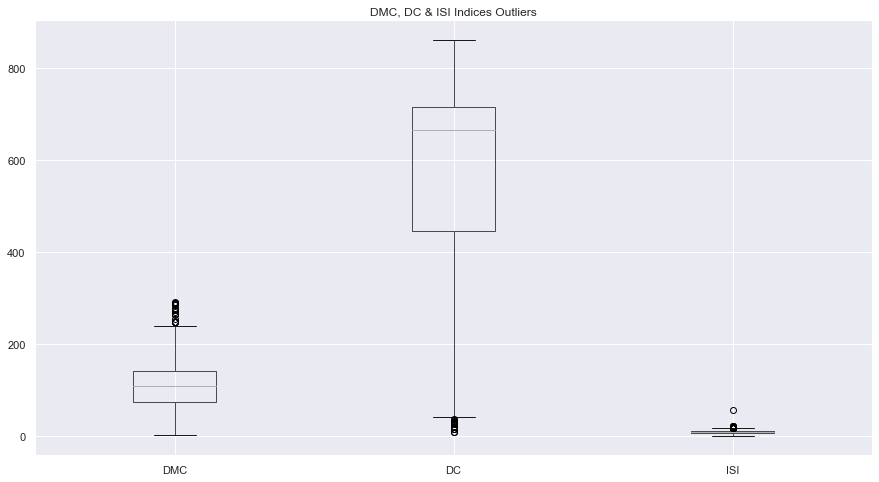

In [1434]:
boxplot = df_new.boxplot(column=['DMC', 'DC', 'ISI'])
boxplot.set_title("DMC, DC & ISI Indices Outliers")

### 4. Feature Selection for Linear Regression

In this section I apply Feature Selection on the dataset and compare the MSE and MAE obtained with **Linear Regression**.

Later in this notebook I apply Feature Selection and then fit a SVR on the dataset.

Dropping the attributes X and Y improved the obtained results.

In [4063]:
df_new.drop('X', axis=1, inplace=True)
df_new.drop('Y', axis=1, inplace=True)

*Splitting the dataset*

In [4064]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_new[df_new.columns[:-1]],  df_new['area'], test_size=0.2)

There are two popular feature selection techniques that can be used for numerical input data and a numerical target variable: Correlation Statistics and Mutual Information Statistics. I decided to use **Correlation Statistics** (reporting linear relationship between each variable) because the obtained results were better.

The scikit-learn machine library provides an implementation of the correlation statistic in the **f_regression() function**. This function can be used in a feature selection strategy, such as **selecting the top k most relevant features** (largest values) via the **SelectKBest class**.

I first defined a function named **select_features(X_train, y_train, X_test, K)** where K is the number of best features that should be considered (features that are the most relevant in predicting the target value).

Then, the function **compare_results(K)** calls the previously defined function **select_features(X_train, y_train, X_test, K)**, scales the newly obtained X_train_fs and X_test_fs datasets (which are subsets of the K most relevant attributes of the original X_train and X_test), reduces their dimensionality (if the number of features is >2), trains a Linear Regression model, predicts the target value and prints out the MSE and MAE.

Then, the **compare_results(K)** is called in a for loop in order to compare the MSE and MAE for subsets of K attributes, where K ranges from 1 to 10.

In [4067]:
def select_features(X_train, y_train, X_test, K):
    # configure to select K features
    fs = SelectKBest(score_func=f_regression, k=K)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [4068]:
def compare_results(K):
    X_train_fs, X_test_fs, fs = select_features(X_train, Y_train, X_test, K)
    scale(X_train_fs, X_test_fs)
    if K>2:
        PCA_func(X_train_fs, X_test_fs)
    model = LinearRegression()
    model.fit(X_train_fs, Y_train)
    yhat = model.predict(X_test_fs)
    print(f'Results obtained with {K} features')
    print(f'MSE: {mean_squared_error(Y_test, yhat)}')
    print(f'MAE: {mean_absolute_error(Y_test, yhat)}')
    print('-------------------------------------------')

In [4069]:
for k in range(10):
    compare_results(k+1)

Results obtained with 1 features
MSE: 0.4420281043956973
MAE: 0.6151044064866501
-------------------------------------------
Results obtained with 2 features
MSE: 0.43683085846421904
MAE: 0.610806068364997
-------------------------------------------
Results obtained with 3 features
MSE: 0.4378933435382091
MAE: 0.6118021052773817
-------------------------------------------
Results obtained with 4 features
MSE: 0.4355205224601032
MAE: 0.6112231642305703
-------------------------------------------
Results obtained with 5 features
MSE: 0.4387225968631809
MAE: 0.6130772983164382
-------------------------------------------
Results obtained with 6 features
MSE: 0.43880354199596766
MAE: 0.6129613801175293
-------------------------------------------
Results obtained with 7 features
MSE: 0.44357832181124895
MAE: 0.6160028854227747
-------------------------------------------
Results obtained with 8 features
MSE: 0.4451809450494237
MAE: 0.6163011810070512
------------------------------------------

In [4065]:
def scale(X_train, X_test):
    scaler = RobustScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

In [4066]:
def PCA_func(X_train, X_test):
    pca_2D = PCA(n_components=2)
    X_train = pca_2D.fit_transform(X_train)
    X_test = pca_2D.transform(X_test)

**Conclusion:** Applying feature selection with different subsets of features did not result with a large difference between the MSEs and the MAEs. Therefore, I will not apply Feature Selection.

### 5. Scaling

Scaling the values with Robust Scaler (scaling the data according to the interquartile range). Since there are outliers in the dataset that I did not drop, the robust scaler will handle them properly.

In [4070]:
scaler = RobustScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 6. Feature Extraction

I will reduce the dimensionality to 2D and 3D and visualize it. In this notebook, I am working with the 2D reduced dataset.

<Figure size 432x288 with 0 Axes>

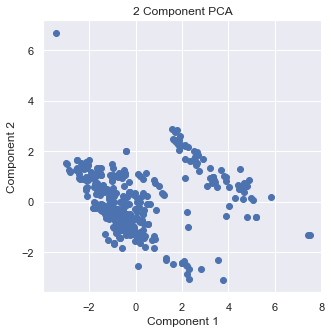

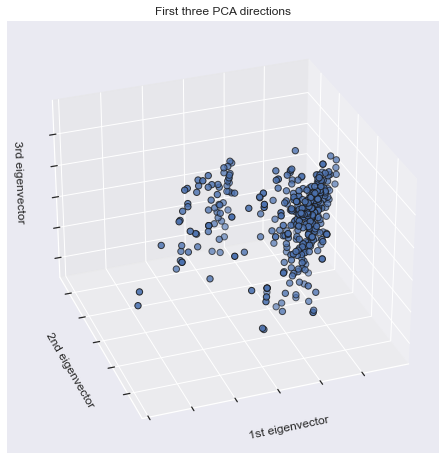

In [4071]:
#2D PCA
pca = PCA(n_components=2)
principalComponents1 = pca.fit_transform(X_train)

PCA_dataset1 = pd.DataFrame(data = principalComponents1, columns = ['component1', 'component2'] )

plt.figure()
plt.figure(figsize=(5,5))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2 Component PCA')
plt.scatter(PCA_dataset1['component1'], PCA_dataset1['component2'])



#3D PCA
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

pca = PCA(n_components=3)
X_reduced = pca.fit(X_train).transform(X_train) 
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.show()

PCA_func(X_train, X_test)

### 7. Linear Regression

In [4072]:
model = LinearRegression().fit(X_train, Y_train)

In [4073]:
y_pred = model.predict(X_test)

In [935]:
#Here, I was reverting the log-transformed dependent variable. I couldn't find a way to revert the box-cox transformation.

#Y_test = np.exp(Y_test)
#y_pred = np.exp(y_pred)

In [4074]:
result_df = pd.DataFrame({"actual":Y_test,"predicted":y_pred})
result_df.head()

,actual,predicted
115,0.000000,0.606241
21,0.000000,0.618926
181,1.196880,0.821276
368,1.434961,0.663255
120,0.000000,0.527453


The mentioned comparison in section 1.3. Handling Skewness is below.

**Results obtained WITHOUT the box-cox transformation on the dependent variable**

In [4028]:
MSE = mean_squared_error(Y_test, y_pred)
RMSE = np.sqrt(MSE)
print(f'MSE: {MSE}')
print(f'RMSE: {RMSE}')

MAE = mean_absolute_error(Y_test, y_pred)
RMAE = np.sqrt(MAE)
print(f'MAE: {MAE}')

MSE: 575.3331314510939
RMSE: 23.986102881691597
MAE: 15.091349541956694


**Results obtained WITH the box-cox transformation on the dependent variable** <br>

We can conclude we did a good job doing a log transformation on the dependent variable.

In [4075]:
MSE_boxcox = mean_squared_error(Y_test, y_pred)
RMSE_boxcox = np.sqrt(MSE_boxcox)
print(f'MSE: {MSE_boxcox}')
print(f'RMSE: {RMSE_boxcox}')

MAE_boxcox = mean_absolute_error(Y_test, y_pred)
RMAE_boxcox = np.sqrt(MAE_boxcox)
print(f'MAE: {MAE_boxcox}')

MSE: 0.43817115243689747
RMSE: 0.6619449768952835
MAE: 0.6107655442970669


#### 7.1. Regularization

Trying to penalize the loss function with different regression algorithms such as **Ridge Regression, Lasso Regression, Elastic Net (combining the L1 and L2 penalty functions) and Bayesian Ridge Regression**. The model variance and the obtained MSE, RMSE, MAE and RMAE are compared in the table below.

Although the difference in the results varies slightly, **Ridge gives the best MSE** (and RMSE consequently) and **the best MAE** (and RMAE consequently). Implementing **Ridge** also results in a model with **lowest variance**.

In [4076]:
algorithms = []
algorithms.append(Ridge(alpha=1))
algorithms.append(Lasso(alpha=0.1))
algorithms.append(ElasticNet(alpha=0.1, l1_ratio = 0.4))
algorithms.append(BayesianRidge())

data = []
for algo in algorithms:
    algo.fit(X_train, Y_train)
    y_pred = algo.predict(X_test)
    sigma = np.sum((Y_test - algo.predict(X_test))**2) / (X_train.shape[0]-2)
    data.append(({
        'MSE': mean_squared_error(Y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(Y_test, y_pred)),
        'MAE': mean_absolute_error(Y_test, y_pred),
        'model variance': sigma
    }))
    
    
results = pd.DataFrame(data=data, columns=['MSE', 'RMSE', 'MAE', 'model variance'],
                       index=['Ridge', 'Lasso', 'ElasticNet', 'BayesianRidge'])

results

,MSE,RMSE,MAE,model variance
Ridge,0.438231,0.661990,0.610861,0.111193
Lasso,0.442423,0.665149,0.614820,0.112257
ElasticNet,0.440105,0.663404,0.614769,0.111669
BayesianRidge,0.439270,0.662775,0.614603,0.111457


#### 7.2. Basis Function Expansion

In this section I expand the linear function to an up to 6 degree polynomial. I compare the results obtained with applying Basis Function Expansion to different algorithms (Linear Regression, Ridge Regression, Lasso Regression, ElasticNet and BayesianRidge).

The function **feature_expansion(algo)** creates features by raising existing features to an exponent. It basically creates new input features based on the existing features, depending on the polynomial degree. The degree of the polynomial (the value of the exponent) is in the range from 1 to 6. <br>
To get an idea of how much the degree impacts the number of features, we will perform the transform with a range of different degrees and compare the number of features in the dataset. The function also calculates the MSE and MAE for some algorithm (algo).

This function is called in a for loop, where in each iteration the argument algo is one of the algorithms in the list algorithms.

In [4082]:
def feature_expansion(algo):
    # calculate change in number of features
    num_features = list()
    degress = [i for i in range(1, 6)]
    for d in degress:
        # create transform
        trans = PolynomialFeatures(degree=d)
        
        # fit and transform
        data = trans.fit_transform(X_train)
        X_train1 = trans.transform(X_train)
        X_test1 = trans.transform(X_test)
        
        model = algo
        model.fit(X_train1, Y_train)
        y_pred1 = model.predict(X_test1)
        
        # record number of features
        num_features.append(data.shape[1])
        
        # summarize
        print('Degree: %d, Features: %d' % (d, data.shape[1]))
        print(f'MSE: {mean_squared_error(Y_test, y_pred1)}')
        print(f'MAE: {mean_absolute_error(Y_test, y_pred1)}')
        print('----------------------------------')
        
    # plot degree vs number of features
    pyplot.plot(degress, num_features)
    pyplot.show()

In [4083]:
algorithms.append(LinearRegression())

On the visualizations for Ridge Regression and Linear Regression we can see that **raising existing features to an exponent larger than 3 leads to worse results**. This can also be noticed in the dramatical increase of the MSE and MAE. <br>For example, in the Linear Regression, raising the features to 3 results with MSE ~6.98. Raising the reatures to 4 results with MSE ~8120.62.

Ridge(alpha=1)
----------------------------------
Degree: 1, Features: 11
MSE: 0.43823074178800653
MAE: 0.610861372417497
----------------------------------
Degree: 2, Features: 66
MSE: 0.4315983256666515
MAE: 0.5927903723999977
----------------------------------
Degree: 3, Features: 286
MSE: 0.8918238712983364
MAE: 0.7112148967194372
----------------------------------
Degree: 4, Features: 1001
MSE: 2.2491499622932247
MAE: 1.020547390320042
----------------------------------
Degree: 5, Features: 3003
MSE: 4.918552062527126
MAE: 1.3964546798499353
----------------------------------


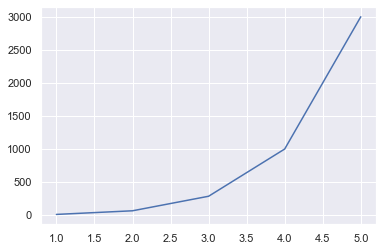

Lasso(alpha=0.1)
----------------------------------
Degree: 1, Features: 11
MSE: 0.4424228482837557
MAE: 0.6148196235476702
----------------------------------
Degree: 2, Features: 66
MSE: 0.4399583952301762
MAE: 0.6151273192598884
----------------------------------
Degree: 3, Features: 286
MSE: 0.45440038455118126
MAE: 0.6185925568142278
----------------------------------
Degree: 4, Features: 1001
MSE: 0.44377492134065394
MAE: 0.611494362085639
----------------------------------
Degree: 5, Features: 3003
MSE: 0.4516718871437247
MAE: 0.6054309815259141
----------------------------------


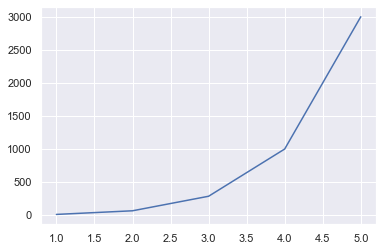

ElasticNet(alpha=0.1, l1_ratio=0.4)
----------------------------------
Degree: 1, Features: 11
MSE: 0.4401052793785753
MAE: 0.6147687042551296
----------------------------------
Degree: 2, Features: 66
MSE: 0.4354332939442558
MAE: 0.6113060800401539
----------------------------------
Degree: 3, Features: 286
MSE: 0.45628461887287725
MAE: 0.6155107483462543
----------------------------------
Degree: 4, Features: 1001
MSE: 0.4593932337244704
MAE: 0.6120273650435766
----------------------------------
Degree: 5, Features: 3003
MSE: 0.4037168856697709
MAE: 0.5767650348839457
----------------------------------


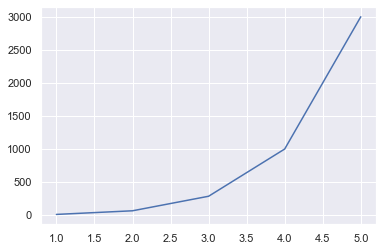

BayesianRidge()
----------------------------------
Degree: 1, Features: 11
MSE: 0.4392701546078368
MAE: 0.614602802622663
----------------------------------
Degree: 2, Features: 66
MSE: 0.43305282842104065
MAE: 0.6101284204472881
----------------------------------
Degree: 3, Features: 286
MSE: 0.4369443957387651
MAE: 0.6128515234429209
----------------------------------
Degree: 4, Features: 1001
MSE: 0.43868317236187726
MAE: 0.6133843959088222
----------------------------------
Degree: 5, Features: 3003
MSE: 0.44243098282643284
MAE: 0.6132783035064034
----------------------------------


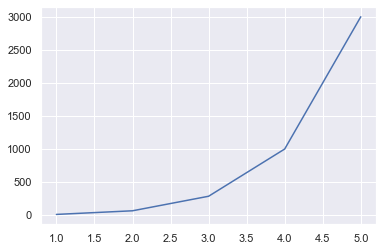

LinearRegression()
----------------------------------
Degree: 1, Features: 11
MSE: 0.43817115243689747
MAE: 0.610765544297067
----------------------------------
Degree: 2, Features: 66
MSE: 0.4442612219979037
MAE: 0.5938369860215963
----------------------------------
Degree: 3, Features: 286
MSE: 6.986891474739407
MAE: 1.5323007656896397
----------------------------------
Degree: 4, Features: 1001
MSE: 8120.62255926954
MAE: 35.870246982630704
----------------------------------
Degree: 5, Features: 3003
MSE: 29076.993618476718
MAE: 44.41696486928604
----------------------------------


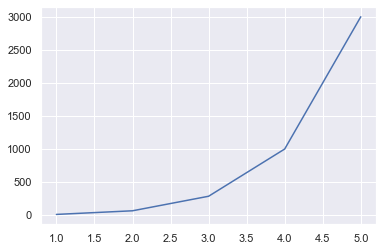

In [4084]:
for algo in algorithms:
    print(algo)
    print('----------------------------------')
    feature_expansion(algo)

### 8. Support Vector Regressor (SVR)

In this section I train two different SVRs - with linear kernel and with polynomial kernel. The MSEs differ only in the 3rd decimal.

**The best MSE so far is obtained with SVR with linear kernel.**

#### 8.1. SVR with linear kernel

In [3546]:
regressor = SVR(kernel='linear', gamma='auto', tol=0.0001, C=0.001, epsilon=0.0001, 
                shrinking=True, cache_size=200, verbose=False, max_iter=100)
regressor.fit(X_train, Y_train)

SVR(C=0.001, epsilon=0.0001, gamma='auto', kernel='linear', max_iter=100,
    tol=0.0001)

In [3547]:
y_pred = regressor.predict(X_test)

In [3549]:
result_df = pd.DataFrame({"actual":Y_test,"predicted":y_pred})
result_df.head()

,actual,predicted
27,0.000000,0.603106
249,0.918205,0.601278
15,0.000000,0.628518
306,0.314863,0.629101
45,0.000000,0.614809


In [3548]:
print(f'MSE: {mean_squared_error(Y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(Y_test, y_pred)}')

MSE: 0.43335345508493983
MAE: 0.5965658425141122


#### 8.2. SVR with polynomial kernel

In [3642]:
regressor = SVR(kernel='poly', degree=3, gamma='auto', tol=0.9, C=0.001, epsilon=0.1, 
                shrinking=True, cache_size=200, verbose=False, max_iter=100)
regressor.fit(X_train, Y_train)

SVR(C=0.001, gamma='auto', kernel='poly', max_iter=100, tol=0.9)

In [3643]:
y_pred = regressor.predict(X_test)

In [3644]:
result_df = pd.DataFrame({"actual":Y_test,"predicted":y_pred})
result_df.head()

,actual,predicted
27,0.000000,0.597712
249,0.918205,0.595758
15,0.000000,0.597764
306,0.314863,0.598430
45,0.000000,0.596468


In [3645]:
print(f'MSE: {mean_squared_error(Y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(Y_test, y_pred)}')

MSE: 0.4343406063022904
MAE: 0.597048688035374


#### 8.3. Feature Selection for a SVR model

By fitting a SVR model with the most significant predictor only, we get a MSE that is almost equal to the MSE obtained with fitting a SVR model with all 10 features.

In [3737]:
X_train_fs, X_test_fs, fs = select_features(X_train, Y_train, X_test, 1)

In [3738]:
regressor = SVR(kernel='rbf', tol=0.1, C=0.1, epsilon=0.0001, 
                shrinking=True, verbose=False, max_iter=100)
regressor.fit(X_train_fs, Y_train)

SVR(C=0.1, epsilon=0.0001, max_iter=100, tol=0.1)

In [3739]:
y_pred = regressor.predict(X_test_fs)

In [3740]:
print(f'MSE: {mean_squared_error(Y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(Y_test, y_pred)}')

MSE: 0.439635556428534
MAE: 0.6009655011759975


### 9. Relevance Vector Machines (RVR)

The MSE obtained with RVR with rbf kernel is slightly better than the MSE obtained with SVR models.

In [3745]:
from sklearn_rvm import EMRVR

clf = EMRVR()
clf.fit(X_train, Y_train)
EMRVR(kernel='rbf')
y_rvr = clf.predict(X_test)

In [3746]:
print(f'MSE: {mean_squared_error(Y_test, y_rvr)}')
print(f'MAE: {mean_absolute_error(Y_test, y_rvr)}')

MSE: 0.4258360875359324
MAE: 0.5865240279065173


### 10. XGBoost

In [3957]:
xg_reg = xgb.XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=0,
       colsample_bytree=0.3, gamma=0.9, learning_rate=0.02, max_delta_step=1,
       max_depth=1, min_child_weight=3, missing=10, n_estimators=102,
       n_jobs=13, nthread=None, objective='reg:linear', random_state=1,
       reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [3960]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]
xg_reg.fit(X_train, Y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=False)
preds = xg_reg.predict(X_test)

[15:27:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [3961]:
print(f'MSE: {mean_squared_error(Y_test, preds)}')
print(f'MAE: {mean_absolute_error(Y_test, preds)}')

MSE: 0.4287351636859109
MAE: 0.5936354919400146


### 11. Random Forest Regressor

In [4004]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 200, random_state = 3)
regressor.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=200, random_state=3)

In [4005]:
y_pred = regressor.predict(X_test)

In [4006]:
print(f'MSE: {mean_squared_error(Y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(Y_test, y_pred)}')

MSE: 0.4883489926213032
MAE: 0.606002636689022


### 12. Deep Learning

In this section I am building an Artificial Neural Network with the unsplit dataset and apply cross validation.
The best MSE so far is obtained with a Neural Network containing 2 layers (input and output).

I am also building an ANN with the split dataset, visualize the results and calculate the r2_score.

####  #1NN

In [3377]:
X = df_new[df_new.columns[:-1]]
Y = df_new['area']

In [3378]:
scaler = RobustScaler()
scaler.fit(X)

X = scaler.transform(X)

In [3382]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [3384]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: -0.55 (0.23) MSE


#### #2NN

In [3411]:
model = Sequential()

model.add(Dense(16, input_dim=10, activation='relu'))

model.add(Dropout(0.2, input_shape=(16,)))

model.add(Dense(8, activation='relu'))

model.add(Dropout(0.2, input_shape=(8,)))

model.add(Dense(1, activation='linear'))

In [3412]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [3413]:
history = model.fit(X_train, Y_train, epochs=30, batch_size=10,  verbose=1, validation_split=0.2)

Epoch 1/30
33/33 [==============================] - 2s 13ms/step - loss: 4.6336 - val_loss: 2.3181
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 2.4464 - val_loss: 1.4178
Epoch 3/30
33/33 [==============================] - 0s 3ms/step - loss: 1.7618 - val_loss: 0.9669
Epoch 4/30
33/33 [==============================] - 0s 2ms/step - loss: 1.3603 - val_loss: 0.7262
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 1.1309 - val_loss: 0.5854
Epoch 6/30
33/33 [==============================] - 0s 3ms/step - loss: 0.8482 - val_loss: 0.5023
Epoch 7/30
33/33 [==============================] - 0s 2ms/step - loss: 0.6626 - val_loss: 0.4506
Epoch 8/30
33/33 [==============================] - 0s 2ms/step - loss: 0.5529 - val_loss: 0.4163
Epoch 9/30
33/33 [==============================] - 0s 2ms/step - loss: 0.5789 - val_loss: 0.4013
Epoch 10/30
33/33 [==============================] - 0s 3ms/step - loss: 0.6349 - val_loss: 0.3920
Epoch 11/30
33/33 

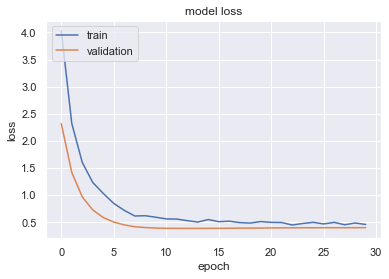

In [3414]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [3415]:
y_pred = model.predict(X_test)

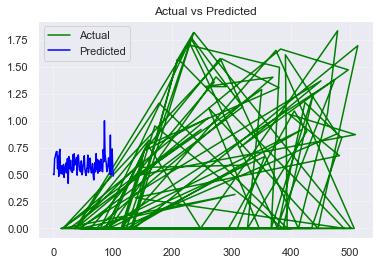

In [3416]:
#Visualising the Acutal and predicted Result
plt.plot(Y_test, color = 'green', label = 'Actual')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.grid(alpha = 0.3)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [3419]:
from sklearn.metrics import r2_score
print("r_square score: ", r2_score(Y_test,y_pred))

r_square score:  0.0147195271173165


### 13. Conclusion

The MSEs and MAEs obtained with different algorithms are shown in the table below. 

**The Neural Network, the ElasticNet on the dataset's features raised to an exponent 5 (in section 7.2. Basis Function Expansion) and the RVR with RBG Kernel give the best 3 MSEs.**

In [4101]:
numpy_data = np.array([["0.438 (0.661)", "0.610"], 
                       ["0.438 (0.661)", "0.610"],
                       ["0.442 (0.665)", "0.615"],
                       ["0.440 (0.663)", "0.615"],
                       ["0.404 (0.636)", "0.577"],
                       ["0.439 (0.663)", "0.615"],
                       ["0.433 (0.658)", "0.596"],
                       ["0.434 (0.659)", "0.597"],
                       ["0.426 (0.653)", "0.586"],
                       ["0.429 (0.655)", "0.594"],
                       ["0.488 (0.698)", "0.606"],
                       ["0.23  (0.48 )", " "]
                      ])

df = pd.DataFrame(data=numpy_data, index=["Linear Regression", "Ridge Regression", "Lasso Regression", "ElasticNet", "ElasticNet (Degree 5)",
                                          "Bayesian Ridge", "SVR (Linear Kernel)", "SVR (Polynomial Kernel)", "RVR (RBF Kernel)", 
                                          "XGBoost","Random Forest Regressor", "A Neural Network"], 
                                          columns=["MSE (RMSE)", "MAE"])
df

,MSE (RMSE),MAE
Linear Regression,0.438 (0.661),0.610
Ridge Regression,0.438 (0.661),0.610
Lasso Regression,0.442 (0.665),0.615
ElasticNet,0.440 (0.663),0.615
ElasticNet (Degree 5),0.404 (0.636),0.577
Bayesian Ridge,0.439 (0.663),0.615
SVR (Linear Kernel),0.433 (0.658),0.596
SVR (Polynomial Kernel),0.434 (0.659),0.597
RVR (RBF Kernel),0.426 (0.653),0.586
XGBoost,0.429 (0.655),0.594
